## Assignment:
This notebook is based on my Data Science class assignement. It aims to predict whether a person has diabetes or not, based on information about the patient such as blood pressure, body mass index (BMI), age, etc. The provided data set is originally from the National Institute of Diabetes and Digestive and Kidney Diseases.  
The Decision tree model will be used to provide predictions.

### Contents:
**A) Explore the dataset**
1) Check the descriptive statistics of the predictor variables.
2) Explore dependent variable. Do we have balanced classes?

**B) Find missing values**
1) Check for missing values - for which variables they occur.
2) Select a strategy to take care of missing values and remove them.

**C) Missing values treatment**
1) Treat the missing values according to the selected strategy(ies), compare basic performance of the resulting models.
2) Select the best approach to treat the missing values.

**D) Final model and its performance**
1) Train model and make predictions with it - done in section C.
2) Pick the best model, inspect and summarize its metrics.
3) Optional: Threshold tuning

**E) Conclusions - what to ask?**
1) Do the parameters make sense? Train vs test evaluation - under/overfitting?
2) Do my predictions make sense?
3) Does model perform well considering metrics?



## ADDITIONAL SOURCES:
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6960014/
- Diabetes risk factors: https://www.cdc.gov/diabetes/basics/risk-factors.html
- Insulin: https://www.levelshealth.com/blog/what-are-normal-insulin-levels-and-why-dont-we-test-it-more

### Import libraries:

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay

In [2]:
from sklearn import __version__
print(__version__)

1.2.2


### Definitions of functions:

In [3]:
def model_pred(df):
    '''
    Function to train a DT model on a given dataframe and to print its metrics
    Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    '''
    
    # select features for dependent variable and split the dataset into a train and test sets 
    column_names = list(df.columns)
    features = [col_x for col_x in column_names if col_x != 'diabetes']
    X = df[features]
    y = df['diabetes']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1, stratify = y)
    
    model = tree.DecisionTreeClassifier()  # default parameters
    model.fit(X_train, y_train)
    
    # predictions for the "train" part of the dataset
    predictions_train = model.predict(X_train)
    predicted_prob_train = model.predict_proba(X_train)
    
    # predictions for the "test" part of the dataset
    predictions_test = model.predict(X_test)
    predicted_prob_test = model.predict_proba(X_test)
    
    return X_train, X_test, y_train, y_test, model, predictions_train, predictions_test, predicted_prob_train, predicted_prob_test

In [4]:
def metrics(y, predictions, predicted_prob):
    '''
    Function to calculate and print metrics for given predictions
    '''
    
    #get confusion matrix, recall and accuracy score
    conf_matrix = confusion_matrix(y, predictions)
    accuracy = accuracy_score(y, predictions)
    recall = recall_score(y, predictions, pos_label = 1) 
    precision = precision_score(y, predictions, pos_label = 1)
    fp_rate = conf_matrix[0][1]/(conf_matrix[0][1] + conf_matrix[0][0])

    # (area under the ROC curve) indicates the probability that the classifier will rank a randomly chosen positive observation higher than a randomly chosen negative one
    auc = roc_auc_score(y, predicted_prob[:,1]) 

    print("Accuracy:", round(accuracy, 2))
    print("Auc:", round(auc,2))
    print("Recall:", round(recall,2))
    print("Precision:", round(precision,2))
    print("FP rate:", round(fp_rate, 2))
    print("Confusion matrix:")
    print(conf_matrix)
    print(" ")
    print("Details:")
    print(classification_report(y, predictions, target_names=[str(i) for i in np.unique(y)]))
    
    return conf_matrix, accuracy, recall, precision, fp_rate, auc

In [5]:
def plot_roc(fpr, tpr, roc_auc, recall_th, fp_rate_th, th_label):   

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, color='darkorange', lw=3, label='area = %0.2f' % roc_auc)
    ax.plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax.hlines(y=recall_th, xmin=0, xmax=fp_rate_th, color='red', linestyle='--', alpha=0.7, label=th_label)
    ax.vlines(x=fp_rate_th, ymin=0, ymax=recall_th, color='red', linestyle='--', alpha=0.7)
    ax.set(xlabel='False Positive Rate', ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")     
    ax.legend(loc=4)
    ax.grid(True)

    plt.show()

In [6]:
def plot_prec_recall(y, precision_graph, recall_graph, precision_th, recall_th):
    no_skill = len(y[y == 1]) / len(y)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall_graph, precision_graph, marker='.', label='DT')
    plt.scatter(recall_th, precision_th, marker='o', color='black', label='th = 0.5')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

In [40]:
def print_metrics(accuracy, recall, fp_rate, precision, auc, conf_matrix):
    print("Accuracy (overall correct pred):", round(accuracy, 2))
    print("Recall (prop. of positives predicted right):", round(recall,2))
    print("FP rate (prop. of negatives falsely predicetd as positives):", round(fp_rate, 2))
    print("Precision (confidence when predicting a positive):", round(precision,2))
    print("Specificity (FN rate) is:", round(1 - fp_rate, 2))
    print("Auc (area under the ROC curve):", round(auc,2))
    print("Number of TP is:", conf_matrix[1][1])
    print("Number of TN is:", conf_matrix[0][0])

## A) Data exploration
Upload dataset, check for its size (# of entries, # of variables), columns, check data values preview.

In [8]:
df = pd.read_csv("Diabetes_data.csv", index_col=0)

In [9]:
df.head(10)

pregnant  glucose  pressure  triceps  insulin  mass  pedigree  age  \
1          6    148.0      72.0     35.0      NaN  33.6     0.627   50   
2          1     85.0      66.0     29.0      NaN  26.6     0.351   31   
3          8    183.0      64.0      NaN      NaN  23.3     0.672   32   
4          1     89.0      66.0     23.0     94.0  28.1     0.167   21   
5          0    137.0      40.0     35.0    168.0  43.1     2.288   33   
6          5    116.0      74.0      NaN      NaN  25.6     0.201   30   
7          3     78.0      50.0     32.0     88.0  31.0     0.248   26   
8         10    115.0       NaN      NaN      NaN  35.3     0.134   29   
9          2    197.0      70.0     45.0    543.0  30.5     0.158   53   
10         8    125.0      96.0      NaN      NaN   NaN     0.232   54   

   diabetes  
1       pos  
2       neg  
3       pos  
4       neg  
5       pos  
6       neg  
7       pos  
8       neg  
9       pos  
10      pos

In [10]:
column_names = list(df.columns)
print(column_names)

['pregnant', 'glucose', 'pressure', 'triceps', 'insulin', 'mass', 'pedigree', 'age', 'diabetes']


In [11]:
df.shape

(768, 9)

**Convert Y-variable to 0/1 values for better handling with the data:**  
Our positive class (1) are people which have diabetes. "Healthy" (in the context of diabetes) represent negative class.

In [12]:
df['diabetes'] = df['diabetes'].map({'pos': 1, 'neg': 0})

### A1) Calculate descriptive statistics and correlation matrix:

In [13]:
df.describe()

pregnant     glucose    pressure     triceps     insulin        mass  \
count  768.000000  763.000000  733.000000  541.000000  394.000000  757.000000   
mean     3.845052  121.686763   72.405184   29.153420  155.548223   32.457464   
std      3.369578   30.535641   12.382158   10.476982  118.775855    6.924988   
min      0.000000   44.000000   24.000000    7.000000   14.000000   18.200000   
25%      1.000000   99.000000   64.000000   22.000000   76.250000   27.500000   
50%      3.000000  117.000000   72.000000   29.000000  125.000000   32.300000   
75%      6.000000  141.000000   80.000000   36.000000  190.000000   36.600000   
max     17.000000  199.000000  122.000000   99.000000  846.000000   67.100000   

         pedigree         age    diabetes  
count  768.000000  768.000000  768.000000  
mean     0.471876   33.240885    0.348958  
std      0.331329   11.760232    0.476951  
min      0.078000   21.000000    0.000000  
25%      0.243750   24.000000    0.000000  
50%      0.372500   29.000000    0.000000  
75%      0.626250   41.000000    1.000000  
max      2.420000   81.000000    1.000000

#### Calculate mean and median values for each 0/1 class

In [14]:
df.groupby('diabetes').mean()

pregnant     glucose   pressure    triceps     insulin       mass  \
diabetes                                                                      
0         3.298000  110.643863  70.877339  27.235457  130.287879  30.859674   
1         4.865672  142.319549  75.321429  33.000000  206.846154  35.406767   

          pedigree        age  
diabetes                       
0         0.429734  31.190000  
1         0.550500  37.067164

In [15]:
df.groupby('diabetes').median()

pregnant  glucose  pressure  triceps  insulin  mass  pedigree   age
diabetes                                                                     
0              2.0    107.0      70.0     27.0    102.5  30.1     0.336  27.0
1              4.0    140.0      74.5     32.0    169.5  34.3     0.449  36.0

#### Plot correlation matrix

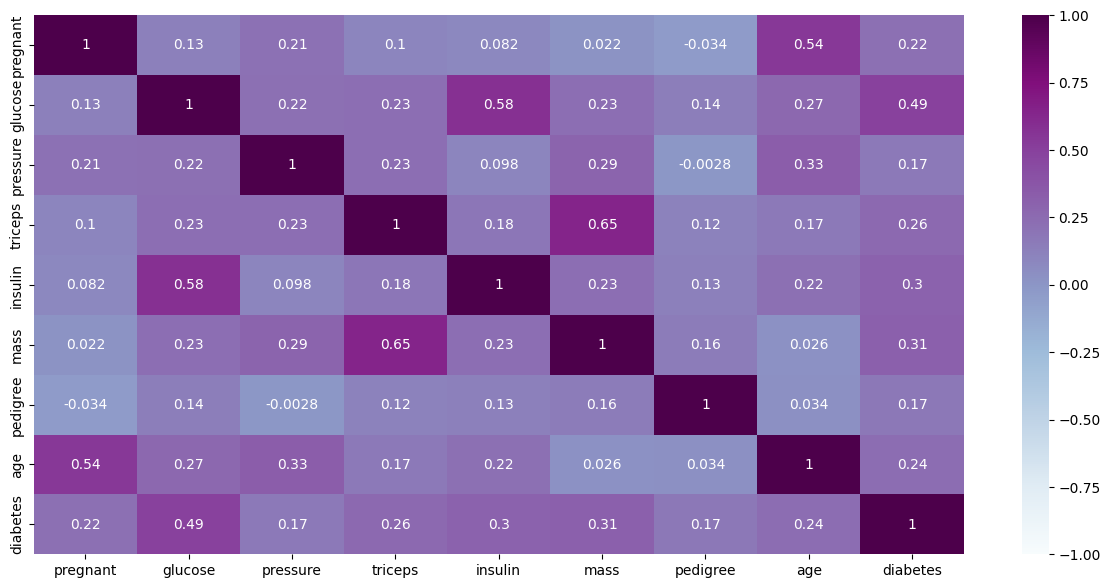

In [16]:
plt.figure(figsize=(15,7))
ax = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap="BuPu", annot=True)

### A2) Inspect the distribution of the dependent Y-variable:

In [17]:
df["diabetes"].value_counts()

diabetes
0    500
1    268
Name: count, dtype: int64

In [18]:
pct_no_diabetes = round(len(df[df["diabetes"]==0])/len(df)*100, 2)
pct_yes_diabetes = round(len(df[df["diabetes"]==1])/len(df)*100, 2)

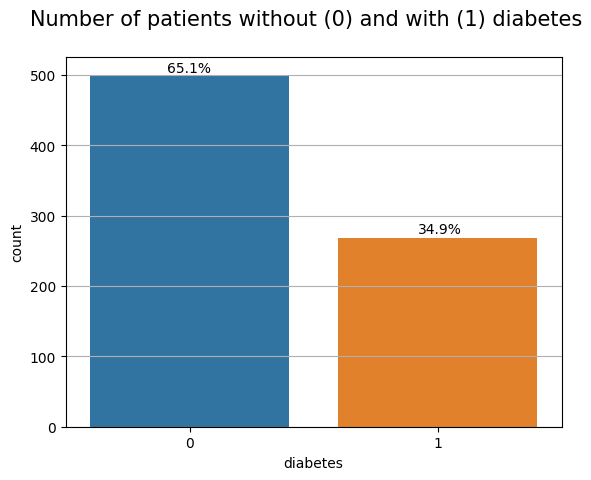

In [19]:
sns.countplot(x = "diabetes", data = df)
plt.text(-0.09, 504, str(pct_no_diabetes)+'%', fontsize=10, color = "black")
plt.text(0.92, 275, str(pct_yes_diabetes)+'%', fontsize=10, color = "black")
plt.grid(axis="y")
plt.suptitle("Number of patients without (0) and with (1) diabetes", fontsize = 15)
plt.show()

### Comments on the data exploration:
- There are in total 9 data columns - 8 independent statistical data columns and 1 dependent variable.

- **Inspection of independent variables:**
    - ***age:*** Our study group contains mostly young and middle-aged adults in their 20s-40s, however some elders/kids are included (with max. age being 81 and min. age 12 years)
    - ***mass:*** Most of the patients are oveweight or obese, with prevalent BMI > 25. High BMI is one of the early risk indicators of the so-called “diseases of civilization”, including diabetes. Moreover, the BMI values are very alerting when the prevalent age of the group is considered.
    - ***pregnant:*** Most frequent value is 3-4 pregnancies, however there are some extremes as 17 pregnancies.
    - ***pressure:*** This varies with the age, however for adults values between 60-80 mm Hg are considered normal and most of our study group seems to fit in this range.
    - ***glucose:*** The normal levels (according to WHO) are (70 - 100) mmol/L. Our study group has in general values at the right side of the interval or higher.
    - ***triceps:*** For this variable, I would need to distinguish between man and women as women in general tend to have higher body fat percentages than men. I could do it by taking those with pregnancies = 0, however this subset can still be both men and women. However in general, normal triceps skinfold thickness is around 15-20 mm while our study group has values mostly > 20 mm.
    - ***insulin:*** (2-Hour serum insulin (mu U/ml))
        - I am confused with the units here (what is mu U?). However normal results should be < 140 mg/dL (neg) and < 180 mg/dL (pos). 
        - The mean/median for the negative subset of patients is considerably lower than for the positive subset.

    
    - The mean and median of the observed values are consistently larger in the positive set of patients. Notably patiens with the positive diagnose of diabetes are 5-10 years older, have much larger BMI, triceps skinfold thickness, and insulin and glucose levels compared to those diagnosed as negatives. The blood pressure and pedigree are not dramatically different.
   

- **Inspection of dependent variable:**
    - ***diabetes:*** diabetes case (pos/neg)
        - We have an imbalanced dataset with ratio neg/pos diabetes approx. 65:35 -> The "neg" set is almost 2x larger.  
        

- **Correlation matrix**
    - The most significant correlation is between 'triceps' and 'mass' variables (0.65) -> This seems netural as people with higher BMI will in general have larger circumferences of the body parts.
    - The next significant is between insulin-glucose (0.58), pregnant-age (0.54), and glucose-diabetes (0.49) -> For the first one, I didn't find any proven connection, the second one seems natural as older women have larger probability, that they were pregnant in the past. And for the last one, it is suggested that a long-term increased glucose levels are indication of (pre)diabetes development (see the sources above).
    - However none of these are highly correlated.
    - Correlation is not large for the rest of the variables.
- **Missing values** -> see the next section B)

## B) Missing values treatment:

### B1) What are the missing values?
- There are lot of missing values in 'insulin' and 'triceps' columns.
- Are values missing at random of is there some bias?
    - Values are missing only in the cases where the diabetes is not diagnosed.
    - This is not to be considered as random -- diagnosed people are probably observed more (initiative coming either from the doctor or the patient) than "healthy" people (even though they may fall into a risk group)

In [20]:
df.isnull().groupby('diabetes').sum()

pregnant  glucose  pressure  triceps  insulin  mass  pedigree  age
diabetes                                                                    
False            0        5        35      227      374    11         0    0

### B2) Treat the missing values
- How to treat missing values?
    - remove columns with the missing values
        - could work for triceps thickness as it tends to be correlated with the BMI (very logical relation), also might work for the insulin level as there is a hint on correlation with the glusoce level
        - however I want to include as many features as possible
    - remove rows with multiple missing values
        - might work for glucose, mass and pressure cases (there are not much of them and the neg group is quite large so it won't be affected that much
        - doing that for the triceps skinfold thickness and insulin level would strip me of a very large portion of the data
    - replace by a mean or median value -> reduces variance of the set
    - more sophisticated imputation - multiple imputation or KNN  
  
  
***I will try these 2 strategies and evaluate the model on them to pick the best one:***
1) df_amputed: Remove columns 'triceps' and 'insulin' + remove rows where 'glucose', 'pressure', and 'mass' are NaN
2) df_mean: Replace missing values with the of the given column
3) df_full: Let the DT algorithm to deal with the missing values

#### Approach 1:

In [21]:
df_amputed = df.drop(columns=['triceps','insulin'])
column_names_amputed = list(df_amputed.columns)
df_amputed = df_amputed.dropna(axis=0)

In [22]:
df_amputed.head(10)

pregnant  glucose  pressure  mass  pedigree  age  diabetes
1          6    148.0      72.0  33.6     0.627   50         1
2          1     85.0      66.0  26.6     0.351   31         0
3          8    183.0      64.0  23.3     0.672   32         1
4          1     89.0      66.0  28.1     0.167   21         0
5          0    137.0      40.0  43.1     2.288   33         1
6          5    116.0      74.0  25.6     0.201   30         0
7          3     78.0      50.0  31.0     0.248   26         1
9          2    197.0      70.0  30.5     0.158   53         1
11         4    110.0      92.0  37.6     0.191   30         0
12        10    168.0      74.0  38.0     0.537   34         1

#### Approach 2:

In [23]:
df_mean = df.copy()
for col in ['triceps', 'insulin', 'glucose', 'pressure', 'mass']:
    df_mean[col] = df_mean[col].fillna(df_mean[col].mean())

column_names_mean = list(df_mean.columns)

In [24]:
df_mean.head(10)

pregnant  glucose   pressure   triceps     insulin       mass  pedigree  \
1          6    148.0  72.000000  35.00000  155.548223  33.600000     0.627   
2          1     85.0  66.000000  29.00000  155.548223  26.600000     0.351   
3          8    183.0  64.000000  29.15342  155.548223  23.300000     0.672   
4          1     89.0  66.000000  23.00000   94.000000  28.100000     0.167   
5          0    137.0  40.000000  35.00000  168.000000  43.100000     2.288   
6          5    116.0  74.000000  29.15342  155.548223  25.600000     0.201   
7          3     78.0  50.000000  32.00000   88.000000  31.000000     0.248   
8         10    115.0  72.405184  29.15342  155.548223  35.300000     0.134   
9          2    197.0  70.000000  45.00000  543.000000  30.500000     0.158   
10         8    125.0  96.000000  29.15342  155.548223  32.457464     0.232   

    age  diabetes  
1    50         1  
2    31         0  
3    32         1  
4    21         0  
5    33         1  
6    30         0  
7    26         1  
8    29         0  
9    53         1  
10   54         1

#### Approach 3:

In [25]:
df_full = df.copy()

# C) Decision tree model

### C1) "Amputed" model
- columns 'triceps' and 'insulin' were dropped
- remaining rows with NaN values dropped (35 rows of negative class affected)

In [26]:
# train the model and get predictions
X_train_amp, X_test_amp, y_train_amp, y_test_amp, model_amp, predictions_train_amp, predictions_test_amp, predicted_prob_train_amp, predicted_prob_test_amp = model_pred(df_amputed)

In [27]:
# get metrics for trainset
conf_matrix_amp_train, accuracy_amp_train, recall_amp_train, precision_amp_train, fp_rate_amp_train, auc_amp_train = metrics(y_train_amp, predictions_train_amp, predicted_prob_train_amp)

Accuracy: 1.0
Auc: 1.0
Recall: 1.0
Precision: 1.0
FP rate: 0.0
Confusion matrix:
[[356   0]
 [  0 187]]
 
Details:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       356
           1       1.00      1.00      1.00       187

    accuracy                           1.00       543
   macro avg       1.00      1.00      1.00       543
weighted avg       1.00      1.00      1.00       543



In [37]:
# get metrics for trainset
conf_matrix_amp_test, accuracy_amp_test, recall_amp_test, precision_amp_test, fp_rate_amp_test, auc_amp_test = metrics(y_test_amp, predictions_test_amp, predicted_prob_test_amp)

Accuracy: 0.65
Auc: 0.65
Recall: 0.63
Precision: 0.49
FP rate: 0.34
Confusion matrix:
[[79 40]
 [23 39]]
 
Details:
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       119
           1       0.49      0.63      0.55        62

    accuracy                           0.65       181
   macro avg       0.63      0.65      0.63       181
weighted avg       0.68      0.65      0.66       181



### C2) "Mean" model
- all NaN values replaced by the mean of the given column

In [29]:
#train the model and get predictions
X_train_mean, X_test_mean, y_train_mean, y_test_mean, model_mean, predictions_train_mean, predictions_test_mean, predicted_prob_train_mean, predicted_prob_test_mean = model_pred(df_mean)

In [30]:
#get metrics
conf_matrix_mean_train, accuracy_mean_train, recall_mean_train, precision_mean_train, fp_rate_mean_train, auc_mean_train = metrics(y_train_mean, predictions_train_mean, predicted_prob_train_mean)

Accuracy: 1.0
Auc: 1.0
Recall: 1.0
Precision: 1.0
FP rate: 0.0
Confusion matrix:
[[375   0]
 [  0 201]]
 
Details:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       375
           1       1.00      1.00      1.00       201

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576



In [31]:
#get metrics
conf_matrix_mean_test, accuracy_mean_test, recall_mean_test, precision_mean_test, fp_rate_mean_test, auc_mean_test = metrics(y_test_mean, predictions_test_mean, predicted_prob_test_mean)

Accuracy: 0.7
Auc: 0.66
Recall: 0.54
Precision: 0.58
FP rate: 0.21
Confusion matrix:
[[99 26]
 [31 36]]
 
Details:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       125
           1       0.58      0.54      0.56        67

    accuracy                           0.70       192
   macro avg       0.67      0.66      0.67       192
weighted avg       0.70      0.70      0.70       192



### C3) DT handling missing values - works only with scikit-learn version >= 1.3

In [ ]:
# train the model and get predictions
X_train_DT, X_test_DT, y_train_DT, y_test_DT, model_DT, predictions_train_DT, predictions_test_DT, predicted_prob_train_DT, predicted_prob_test_DT = model_pred(df_full)

In [ ]:
#get metrics
conf_matrix_imp_train, accuracy_imp_train, recall_imp_train, precision_imp_train, fp_rate_imp_train, auc_imp_train = metrics(y_train_imp, predictions_train_imp, predicted_prob_train_imp)

In [ ]:
#get metrics
conf_matrix_imp_test, accuracy_imp_test, recall_imp_test, precision_imp_test, fp_rate_imp_test, auc_imp_test = metrics(y_test_imp, predictions_test_imp, predicted_prob_test_imp)

## D) Final model

#### Model parameters:
These are the default parameters. They can be fine-tuned manually when initiating the model.  
For available parameters and their options, see here:  
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html  
Moreover, the final model should be tested on a test

In [32]:
model_amp.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

#### How does the final tree look like?

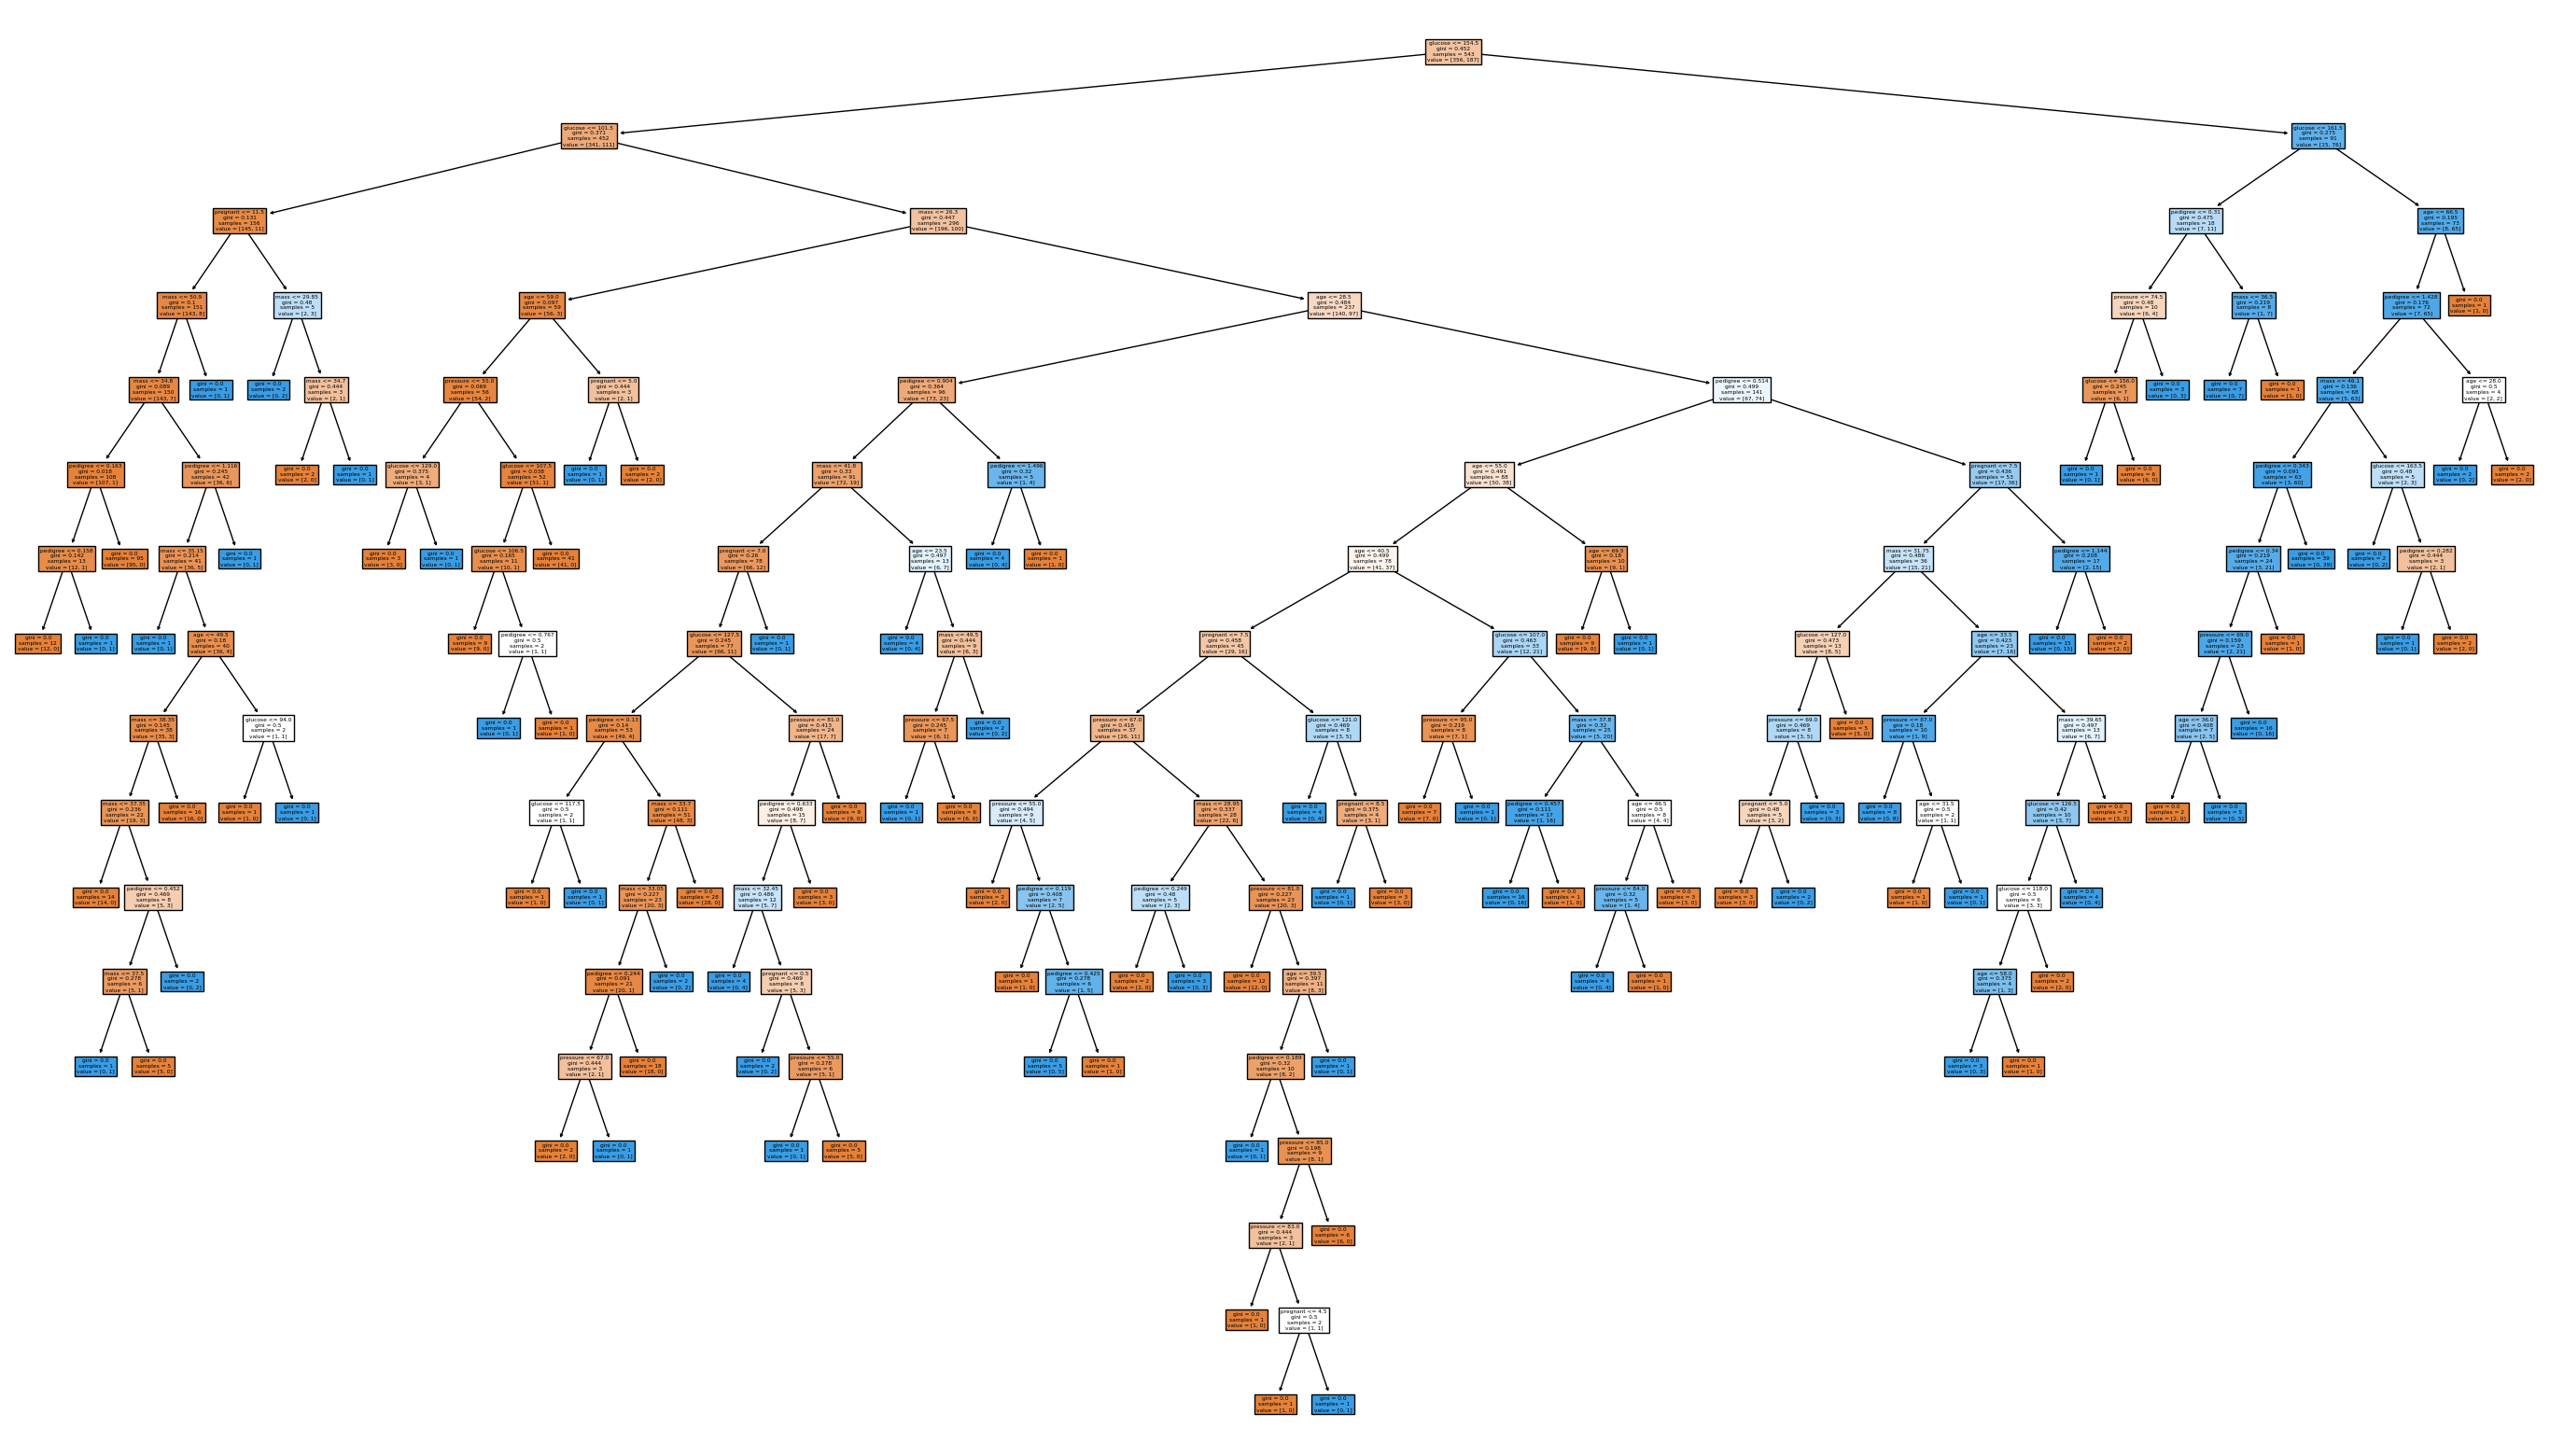

In [34]:
fig = plt.figure(figsize=(35,20))
tree.plot_tree(model_amp, filled=True, feature_names=X_train_amp.columns)
plt.show()

#### **WHOA!**  Some comments are in order here :)
- If the tree above is too complex and your prediction metrics on test data are very poor compared to training metrics, it seems that you got an overfitted model. Try to tweak DT parameters (start e.g. with tree depth) to get better results. :)  
- Suggestion: The above approach can be done iteratively for different parameter options and you can then inspect dependence of metrics on parameters -> it may show that below/above some values, metrics reach its boundaries and you reached an overfitted model. You can do this either manually (fitting several models and getting its metrics in a for loop), or use prepared machinery called **grid search** to inspect a parameter space of your choice, see: https://scikit-learn.org/stable/modules/grid_search.html  
- Moreover, you selection of train/test split may not be optimal -> **cross-validation** is a good thing to do! See here: https://scikit-learn.org/stable/modules/cross_validation.html  


### D1) Model metrics:
Check here for definitions and explanation: https://developers.google.com/machine-learning/crash-course/classification/video-lecture

#### Confusion matrix:

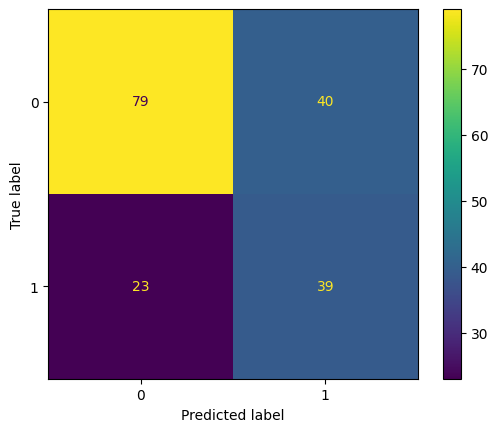

In [38]:
ConfusionMatrixDisplay.from_estimator(model_amp, X_test_amp, y_test_amp)
plt.show()

#### Summary of the model metrics:

In [41]:
print_metrics(accuracy_amp_test, recall_amp_test, fp_rate_amp_test, precision_amp_test, auc_amp_test, conf_matrix_amp_test)

Accuracy (overall correct pred): 0.65
Recall (prop. of positives predicted right): 0.63
FP rate (prop. of negatives falsely predicetd as positives): 0.34
Precision (confidence when predicting a positive): 0.49
Specificity (FN rate) is: 0.66
Auc (area under the ROC curve): 0.65
Number of TP is: 39
Number of TN is: 79


#### ROC curve (recall vs FP rate)

Prediction classes: [0 1]


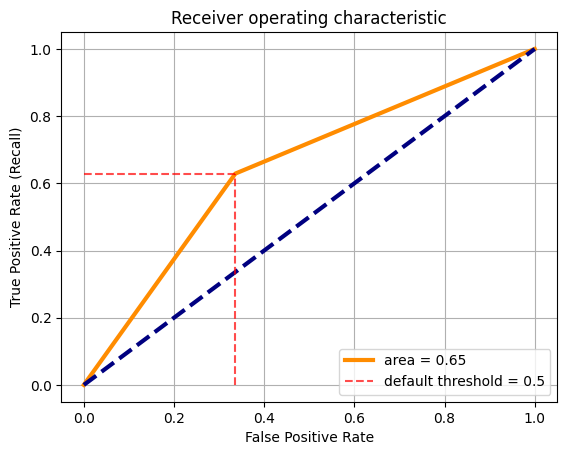

In [42]:
classes = np.unique(y_test_amp)
print("Prediction classes:", classes)
fpr, tpr, thresholds = roc_curve(y_test_amp, predicted_prob_test_amp[:,1], pos_label = 1)
roc_auc = auc(fpr, tpr)  
plot_roc(fpr, tpr, roc_auc, recall_amp_test, fp_rate_amp_test, "default threshold = 0.5")

#### Precision-recall curve

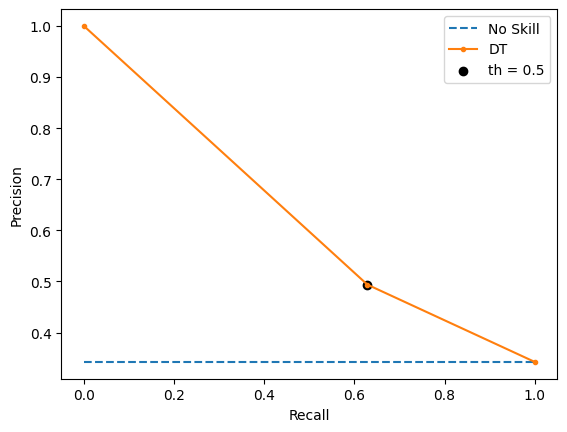

In [43]:
precision, recall, ths = precision_recall_curve(y_test_amp, predicted_prob_test_amp[:, 1], pos_label = 1)
plot_prec_recall(y_test_amp, precision, recall, precision_amp_test, recall_amp_test)

### D2) Threshold tuning:
- One can tune threshold in order to focus on one of the classes and optimize its result - e.g. not having many FPs is more important than maximized recall -> I will do tuning so that I lower down FP rate while maintaining acceptable recall
- This can be done by several approaches, for a review see here:  
https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/